###  <span style="color:red">If you like this kernel then please upvote. It'll motivate me for making more kernels like this.</span>

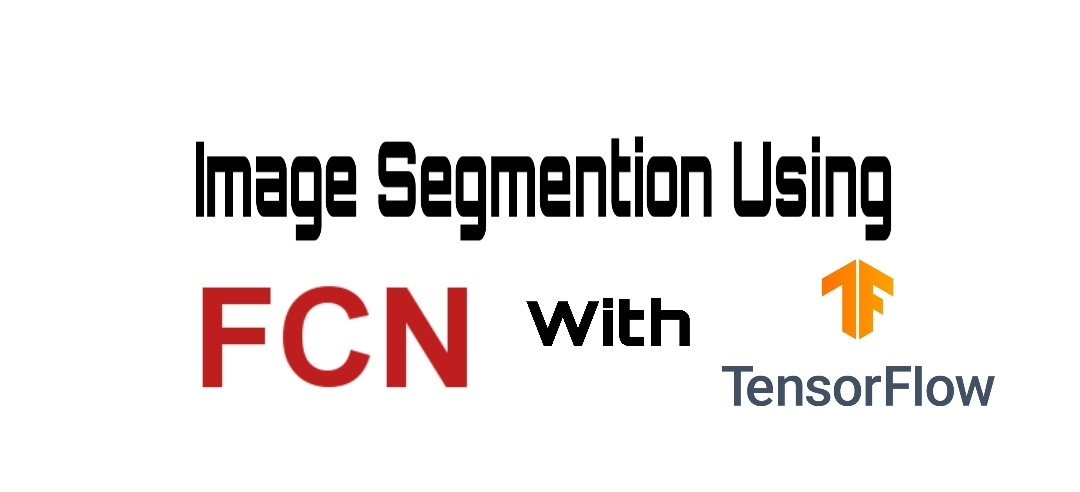

In this kernel we're going to do:
1. what is image segmentation.
2. what is FCN(fully Convolutional Networks).
3. Implementing FCN model from the paper.
4. Train the model into dataset Oxford-IIIT pet dataset.

What is Image Segmentation?

Image segmentation is a critical process in computer vision. It involves dividing a visual input into segments to simplify image analysis. Segments represent objects or parts of objects, and comprise sets of pixels, or “super-pixels”. Image segmentation sorts pixels into larger components, eliminating the need to consider individual pixels as units of observation.

Fully Convolutional Networks (FCNs) owe their name to their architecture, which is built only from locally connected layers, such as convolution, pooling and upsampling. Note that no dense layer is used in this kind of architecture. This reduces the number of parameters and computation time. Also, the network can work regardless of the original image size, without requiring any fixed number of units at any stage, givent that all connections are local. To obtain a segmentation map (output), segmentation networks usually have 2 parts :
* Downsampling path : capture semantic/contextual information
* Upsampling path : recover spatial information

The downsampling path is used to extract and interpret the context (what), while the upsampling path is used to enable precise localization (where). Furthermore, to fully recover the fine-grained spatial information lost in the pooling or downsampling layers, we often use skip connections.

A skip connection is a connection that bypasses at least one layer. Here, it is often used to transfer local information by concatenating or summing feature maps from the downsampling path with feature maps from the upsampling path. Merging features from various resolution levels helps combining context information with spatial information.

    fig FCN architecture 
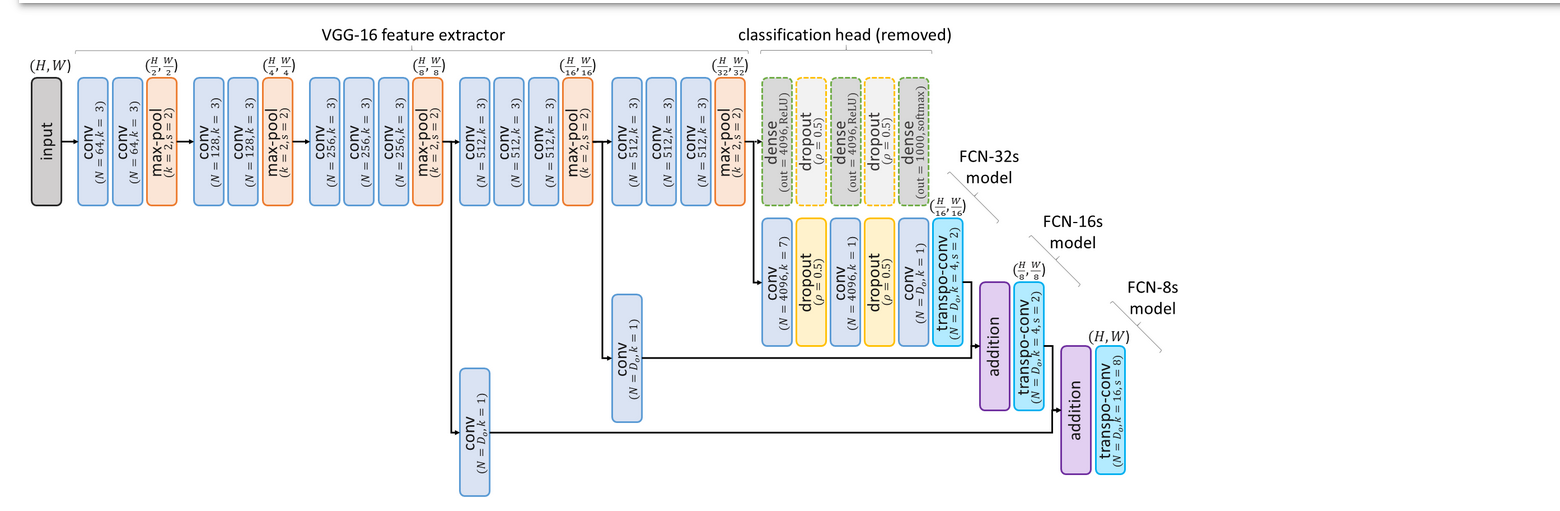

Now, let's download and prepare our dataset Oxford-IIIT pet dataset.     .
The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.

It's already available in tensorflow datasets, So we're going to use it.

In [1]:
# Installing tensorflow datasets
!pip install -U tfds-nightly

     |████████████████████████████████| 3.7 MB 3.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# importing the libraries
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
# downloading the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
# function to normalize the dataset,i.e the pixel value ranges from 0-1
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
# resizing the train dataset image to H x W = 128 x 128
# performing image augmentation to increase the dataset size
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
# resizing the test dataset image to H x W = 128 x 128
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
# defining some hyperparameters
TRAIN_LENGTH = info.splits['train'].num_examples
BUFFER_SIZE = 1000
BATCH_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
# defining the input pipeline
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
c
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
# function for showing sample images and its mask from the dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

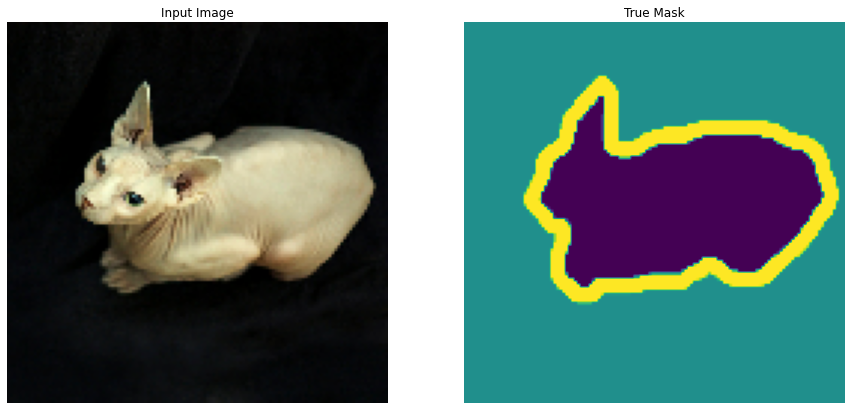

In [10]:
# train.take(1) method takes the first element f
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

FCN models have been developed for semantic segmentation.
This models uses pre-trained VGG-16 for feature extraction, adding on top some layers to concatenate and upsample the feature maps into pixel-level predictions.
In this fig, you can see how it has been used and connected.
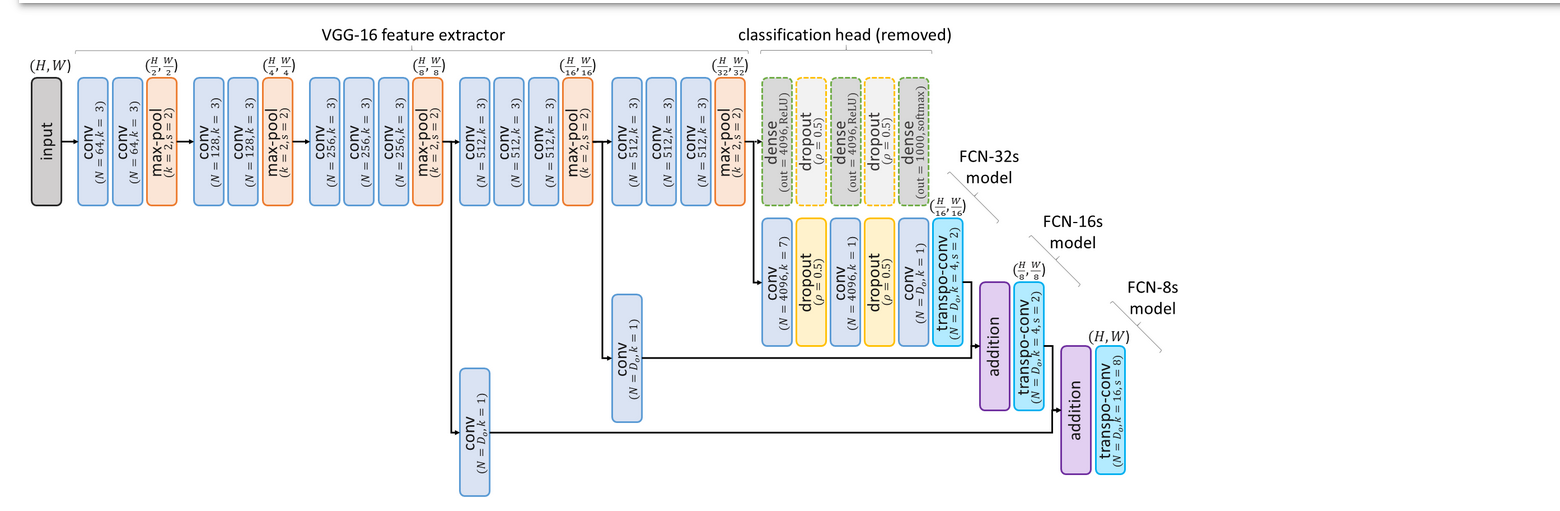

We're going to use pre-trained VGG-16 model from keras.applications .
This model is trained on imagenet dataset. We're loading the VGG-16
model without the last fully connected dense layers.

And now let's try to implement the FCN model from looking the
above architecure.
And we're using keras functional API for defining the model.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [12]:
def fcn(image_size, ch_in=3, ch_out=3):
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [13]:
# defining the tensorflow distribute strategy
strategy = tf.distribute.MirroredStrategy()

In [14]:
# calling the model inside the scope
with strategy.scope():
  model = fcn(image_size=(128, 128))
  # compiling the model with the optimizer, loss function and acc metrics
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


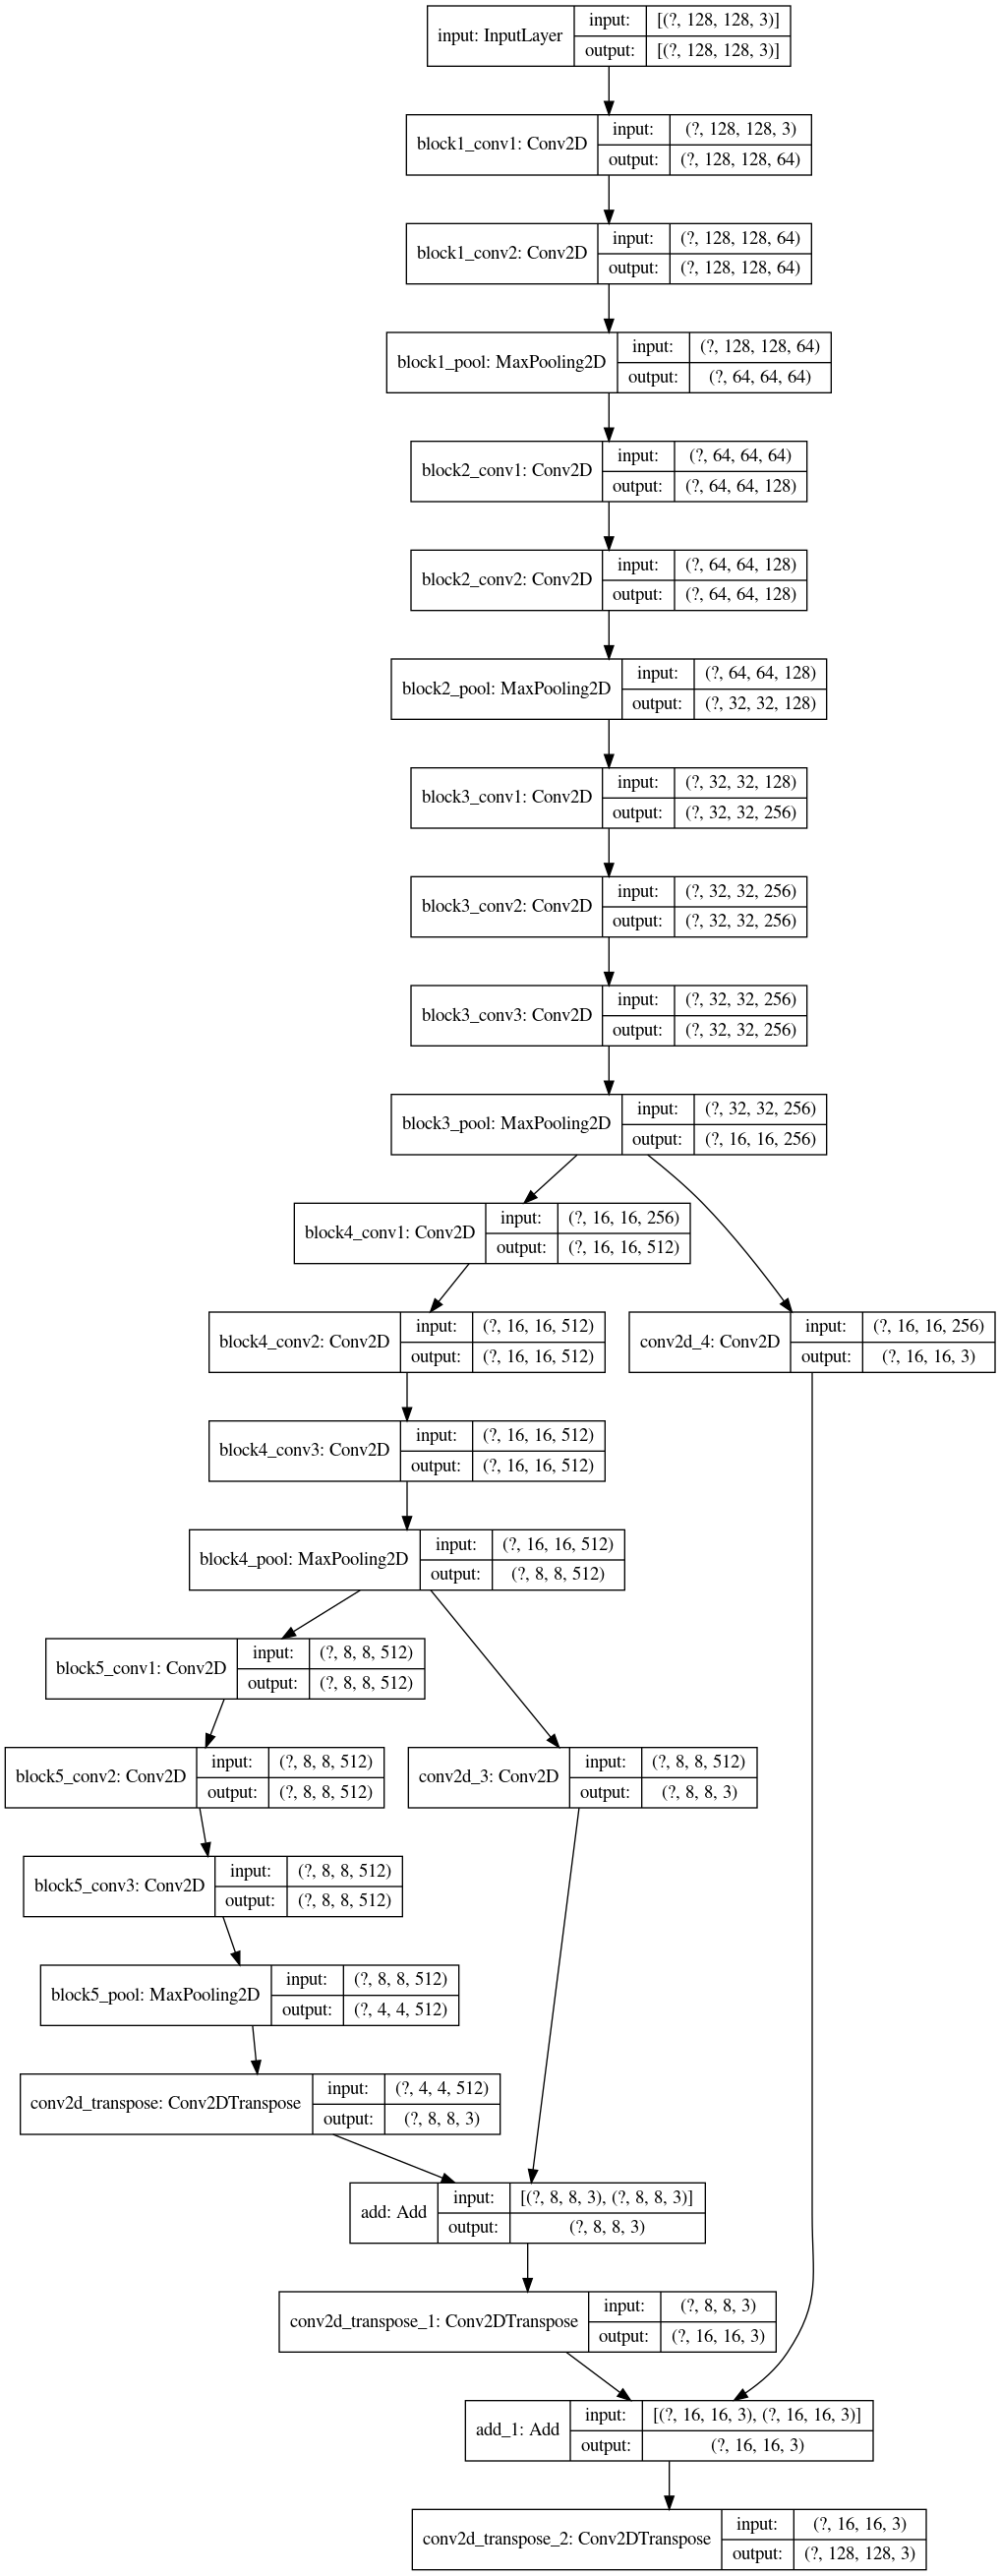

In [15]:
# let's see how our FCN implemented model looks like
# does it looks like the architecture fig above?
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
# function to create the mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [17]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

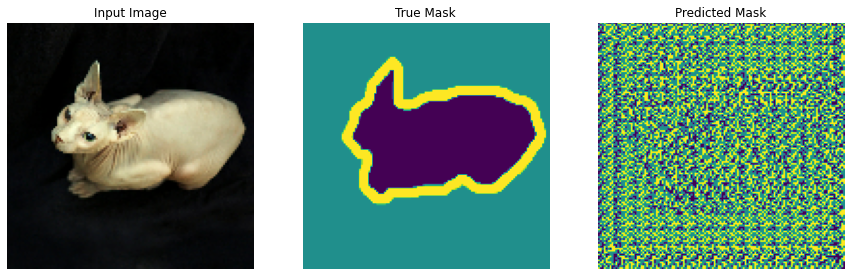

In [18]:
# Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions()

In [19]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)


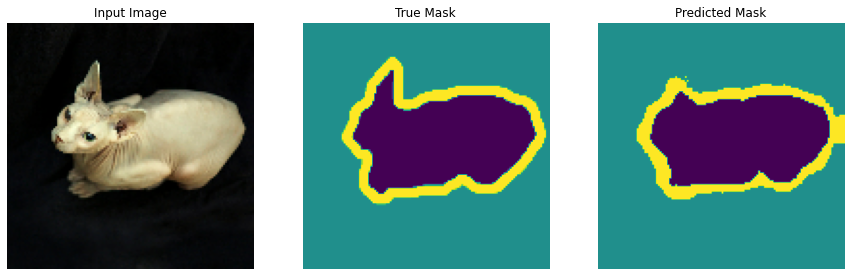


Sample Prediction after epoch 50

28/28 [==============================] - 11s 389ms/step - loss: 0.1883 - accuracy: 0.9161 - val_loss: 0.3740 - val_accuracy: 0.8718 - lr: 0.0010


In [20]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), reduce_lr, early_stopping])

This all for this kernel. Hope you enjoyed it.

<span style="color:red">**If you've learned anything then please upvote this notebook. This will motivate me for contributing more kagle kernels to kaggle community.**</span>

Refrences: 
1. https://www.tensorflow.org/tutorials/images/segmentation
2. https://arxiv.org/abs/1411.4038
